## Generate the OOD datasets for SVRT task 1

In [11]:
import os
import io
import math
import copy 
import random
import numpy as np
#import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from itertools import permutations
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Helper data generation functions.
def serialize_array(array):
    array = tf.io.serialize_tensor(array)
    return array

def regular_polygon(sides, radius=10, rotation=0, translation=None):
    """Calculates the vertices of a regular polygon by sweeping out a circle, and puting n equally spaced points on it."""
    # The first thing to do is work out the angle (in radians) of each wedge from the center outwards.
    # The total number of radians in a circle is 2 pi, so our value is 2 pi / n per segment.
    one_segment = math.pi * 2 / sides
    # After that a bit of basic trig gives us our points. At this point we scale by our desired radius,
    # and have the opportunity to offset the rotation by a fixed amount too.
    points = [
        (int(math.sin(one_segment * i + rotation) * radius),
         int(math.cos(one_segment * i + rotation) * radius))
        for i in range(sides)]

    original_points = copy.copy(points)
    # After that we translate the values by a certain amount, because you probably want your polygon
    # in the center of the screen, not in the corner.
    if translation:
        points = [[sum(pair) for pair in zip(point, translation)]
                  for point in points]
    return points, original_points

def open_rectangle(radius=8, x_offset=None, rotation=None, translation=None):
    if rotation is None:
        rotation =  1 * math.pi * np.random.random_sample()

    if x_offset is None:
        x_offset = np.random.randint(8)

    sides = 4
    one_segment = math.pi * 2 / sides
    points = [
        (math.sin(one_segment * i + rotation) * radius,
         math.cos(one_segment * i + rotation) * radius)
        for i in range(sides)]

    line_1 = points[0:2]
    line_2 = points[2:4]
    line_2 = [[p[0] - x_offset, p[1]] for p in line_2]
    original_lines = copy.copy([line_1, line_2])

    if translation:
        line_1 = [[sum(pair) for pair in zip(point, translation)]
                  for point in line_1]
        line_2 = [[sum(pair) for pair in zip(point, translation)]
                  for point in line_2]
    lines = [line_1, line_2]

    return lines, original_lines

def ccw_sort(polygon_points):
    """Sort the points counter clockwise around the mean of all points. The sorting can be imagined like a
    radar scanner, points are sorted by their angle to the x axis."""
    polygon_points = np.array(polygon_points)
    mean = np.mean(polygon_points,axis=0)
    d = polygon_points-mean
    s = np.arctan2(d[:,0], d[:,1])
    return polygon_points[np.argsort(s),:]

def iregular_polygon_from_regular(sides, radius=1, rotation=0, translation=None, max_dev=0):
    # Get regular polygon.
    points, original_points = regular_polygon(sides=sides, radius=radius, rotation=rotation, translation=translation)

    # Add noise.
    noise = [[np.random.randint(-max_dev, max_dev+1), np.random.randint(-max_dev, max_dev+1)] for x in points]
    points = [[x[0] + y[0], x[1] + y[0]] for x, y in zip(points, noise)]
    original_points = [[x[0] + y[0], x[1] + y[0]] for x, y in zip(original_points, noise)]
    
    # Return points and cero-centerd points.
    return ccw_sort(points), ccw_sort(original_points)

def divide_polygon(points):
    """Divides polygon at the midsection of every side.
    Args:
        points: list of points.
    Returns:
        List of lits of points."""
    mid_points = []
    for i in range(len(points)):
        if i == len(points) - 1:
            midpoint = [(points[i][0] + points[0][0]) / 2, (points[i][1] + points[0][1]) / 2]
        else:
            midpoint = [(points[i][0] + points[i+1][0]) / 2, (points[i][1] + points[i+1][1]) / 2]
        mid_points.append(midpoint)

    new_points = []
    for i in range(len(mid_points)):
        if i == len(mid_points) - 1:
            new_points.append([mid_points[i], points[i], points[0]])
        else:
            new_points.append([mid_points[i], points[i], points[i+1]])

    return new_points

def displace_line_around_origin(point_list, d):
    """Displace a line (list of points) away from the center (0, 0) d units."""
    point = point_list[1]
    x, y = point
    d_x = d if x >= 0 else -d
    d_y = d if y >= 0 else -d
    displacement = [d_x, d_y]

    displaced_point_list = [[sum(pair) for pair in zip(point, displacement)] for point in point_list]
    
    return displaced_point_list

def displace_polygon_vertices(list_of_points, radius):
    """Displace polygon subseccions randomly around the center.
    The displacement keeps the angles of the original polygon.
    This function assumes that points are the original polygon
    points around the coordinate (0,0).

    Args:
        points: list of points.
    Returns:
        List of lits of points."""
    
    mid_points = []
    for i in range(len(list_of_points)):
        if i == len(list_of_points) - 1:
            midpoint = [(list_of_points[i][0] + list_of_points[0][0]) / 2, (list_of_points[i][1] + list_of_points[0][1]) / 2]
        else:
            midpoint = [(list_of_points[i][0] + list_of_points[i+1][0]) / 2, (list_of_points[i][1] + list_of_points[i+1][1]) / 2]
        mid_points.append(midpoint)

    new_points = []
    for i in range(len(mid_points)):
        if i == len(mid_points) - 1:
            new_points.append([mid_points[i], list_of_points[0], mid_points[0]])
        else:
            new_points.append([mid_points[i], list_of_points[i+1], mid_points[i+1]])

    # All posible displacements to sample from.
    all_d = list(range(0, radius))
    random.shuffle(all_d)

    # Displace the points from the distance a randomly chosen amount.
    displaced_points = []
    counter = 0
    for point_list in new_points:
        d = all_d[counter]  # random.sample(all_d, 1)[0]
        new_point_list = displace_line_around_origin(point_list, d)
        displaced_points.append(new_point_list)
        counter += 1
        # Reset the counter if reach the end of all displacements.
        if counter >= len(all_d) - 1:
            counter = 0
    
    return displaced_points

def scramble_poligon(img, midpoint, radius):
    # Augment the radius to cover all pixels in teh target patch. 
    radius += 1
    # Get start points and end points fo the 4 quadrants.
    sp_1 = (midpoint[0]-radius, midpoint[1]-radius)
    ep_1 = midpoint

    sp_2 = (midpoint[0], midpoint[1]-radius)
    ep_2 = (midpoint[0]+radius, midpoint[1])

    sp_3 = (midpoint[0]-radius, midpoint[1])
    ep_3 = (midpoint[0], midpoint[1]+radius)

    sp_4 = midpoint
    ep_4 = (midpoint[0]+radius, midpoint[1]+radius)

    # Sample offsets.
    off_x = random.sample(list(range(0, int(radius/2))), 4)
    off_y = random.sample(list(range(0, int(radius/2))), 4)
    
    # Add offsets.
    new_sp_1 = (sp_1[0]-off_x[0], sp_1[1]-off_y[0])
    new_ep_1 = (ep_1[0]-off_x[0], ep_1[1]-off_y[0])

    new_sp_2 = (sp_2[0]+off_x[1], sp_2[1]-off_y[1])
    new_ep_2 = (ep_2[0]+off_x[1], ep_2[1]-off_y[1])

    new_sp_3 = (sp_3[0]-off_x[2], sp_3[1]+off_y[2])
    new_ep_3 = (ep_3[0]-off_x[2], ep_3[1]+off_y[2])

    new_sp_4 = (sp_4[0]+off_x[3], sp_4[1]+off_y[3])
    new_ep_4 = (ep_4[0]+off_x[3], ep_4[1]+off_y[3])
    
    # Copy patches.
    patch_1 = np.copy(img[sp_1[1]:ep_1[1], sp_1[0]:ep_1[0]])
    patch_2 = np.copy(img[sp_2[1]:ep_2[1], sp_2[0]:ep_2[0]])
    patch_3 = np.copy(img[sp_3[1]:ep_3[1], sp_3[0]:ep_3[0]])
    patch_4 = np.copy(img[sp_4[1]:ep_4[1], sp_4[0]:ep_4[0]])

    # Wipe out patches in img.
    img[sp_1[1]:ep_1[1], sp_1[0]:ep_1[0]] = (255, 255, 255 )
    img[sp_2[1]:ep_2[1], sp_2[0]:ep_2[0]] = (255, 255, 255 )
    img[sp_3[1]:ep_3[1], sp_3[0]:ep_3[0]] = (255, 255, 255 )
    img[sp_4[1]:ep_4[1], sp_4[0]:ep_4[0]] = (255, 255, 255 )

    # Paste patches in new locations.
    img[new_sp_1[1]:new_ep_1[1], new_sp_1[0]:new_ep_1[0]] = patch_1
    img[new_sp_2[1]:new_ep_2[1], new_sp_2[0]:new_ep_2[0]] = patch_2
    img[new_sp_3[1]:new_ep_3[1], new_sp_3[0]:new_ep_3[0]] = patch_3
    img[new_sp_4[1]:new_ep_4[1], new_sp_4[0]:new_ep_4[0]] = patch_4

    return img

def svrt_1_points_open_rectangle(category=1, radii=None, rotation=None):
    # Polygon parameters.
    if rotation is None:
        rotation = math.pi/4  # 2 * math.pi * np.random.random_sample()

    # Positions.
    min_dev_1 = 16
    translation_a = [np.random.randint(min_dev_1, 128-min_dev_1), np.random.randint(min_dev_1, 128-min_dev_1)]
    
    # Ensure that the second shape is at the other side of at least one dimension.
    choice_x = False if np.random.random_sample() < 0.5 else True
    if choice_x:
        t2_x = np.random.randint(22, 32) if translation_a[0] > 64 else np.random.randint(90, 102)
    else:
        t2_x = np.random.randint(22, 102)
    choice_y = True if choice_x is False else False if np.random.random_sample() < 0.5 else True
    if choice_y:
        t2_y = np.random.randint(22, 32) if translation_a[1] > 64 else np.random.randint(90, 102)
    else:
        t2_y = np.random.randint(22, 102)
    
    translation_b = [t2_x, t2_y]

    # Generate points.
    if category == 0:
        x_offset_1 = np.random.choice(11)
        # At least 4 points of difference in width.
        offset_diference = np.random.choice(range(4, 8))
        x_offset_2 = x_offset_1 + offset_diference if np.random.random_sample() > 0.5 else x_offset_1 - offset_diference
        points_a , _ = open_rectangle(translation=translation_a, x_offset=x_offset_1, rotation=rotation) # List of lits of points.
        points_b , _ = open_rectangle(translation=translation_b, x_offset=x_offset_2, rotation=rotation) # List of lits of points.

    elif category == 1:
        points_a , original_a = open_rectangle(translation=translation_a, rotation=rotation) # List of lits of points.
        line_1, line_2 = original_a
        line_1 = [[sum(pair) for pair in zip(point, translation_b)]
                  for point in line_1]
        line_2 = [[sum(pair) for pair in zip(point, translation_b)]
                  for point in line_2]
        points_b = [line_1, line_2]

    else:
        raise ValueError('category has to be 1 or 0!') 

    return points_a, points_b

def svrt_1_img_open_rectangle(
    category=1,
    thickness=1,
    color=(0,0,0),
    rotation=None,
    closed=False):

    # Array of size 128x128 filled with ones as values, to create an image with black color.
    img = np.zeros(shape=(128,128,3),dtype=np.int16)
    img[:] = (255, 255, 255)  # Changing the color of the image

    # Make a second img with connected lines to get bounding boxes later on.
    img2 = np.zeros(shape=(128,128,3),dtype=np.int16)
    img2[:] = (255, 255, 255)  # Changing the color of the image

    # Get points.
    points_a, points_b = svrt_1_points_open_rectangle(category=category, rotation=rotation)

    # Draw.
    for line in points_a:
        poly_a = np.array(line,dtype=np.int32)
        # Reshaping according to opencv format.
        poly_new_a = poly_a.reshape((-1,1,2))
        cv2.polylines(img, [poly_new_a], isClosed=closed, color=color, thickness=thickness)
        cv2.polylines(img2, [poly_new_a], isClosed=closed, color=color, thickness=thickness)

    for line in points_b:
        poly_b = np.array(line,dtype=np.int32)
        # Reshaping according to opencv format.
        poly_new_b = poly_b.reshape((-1,1,2))
        cv2.polylines(img, [poly_new_b], isClosed=closed, color=color, thickness=thickness)
        cv2.polylines(img2, [poly_new_b], isClosed=closed, color=color, thickness=thickness)
    
    # Connect lines in img2 only.
    points_c = [[points_a[0][0], points_a[1][0]], [points_b[0][0], points_b[1][0]]]
    for line in points_c:
        poly_c = np.array(line,dtype=np.int32)
        # Reshaping according to opencv format.
        poly_new_c = poly_c.reshape((-1,1,2))
        cv2.polylines(img2, [poly_new_c], isClosed=closed, color=color, thickness=thickness)

    return img.astype('uint8'), img2.astype('uint8')

def svrt_1_points(category=1, radii=None, sides=None, rotations=None, regular=False,
                  irregularity=0.25, displace_vertices=False):
    """Returns polygon points for a single instance of a SVRT problem 1.
    Args:
        category: 0 (no) or 1 (yes).
        radii: radii of the base regular polygon. 2-tuple 8 to 14.
        sides: number of sides of the base regular polygon. 2-tuple 4 to 8.
        rotations: rotations of the polygons. 2-tuple 4 to 8.
        regular: whether to build regular or irregular polygons in radiants. 2-tuple form 0 to pi.
        irregularity: maximum level of random point translation for irregular polygons.
        displace_vertices: if True displaces second polygon subseccions randomly around its center in the positive cases.
    Returns:
        Two lists of polygon points."""

    # Polygon parameters.
    if radii is None:
        if displace_vertices:
            radius_1 = np.random.randint(8, 10)  #  (10, 18)
            radius_2 = radius_1 #if category==1 else np.random.randint(10, 14)
        else:
            radius_1 = np.random.randint(8, 20) # (10, 40) # np.random.randint(10, 14)
            radius_2 = radius_1 #if category==1 else np.random.randint(10, 40)
    else:
        radius_1, radius_2 = radii

    if sides is None:
        if displace_vertices:
            possible_sides = random.sample(list(range(3, 8)), 2)
        else:
            possible_sides = random.sample(list(range(3, 8)), 2)
        sides_1 = possible_sides[0]
        sides_2 = possible_sides[1]

    if rotations is None:
        rotation_1 = math.radians(random.randint(0, 360))
        rotation_2 = math.radians(random.randint(0, 360))

    # I need to calculate min_dev_1 based on the actual points not based on the maximum posible enclosing circle...
    
    if not regular and irregularity is None:
        max_dev_factor = np.random.choice([0.3, 0.4])
    else:
        max_dev_factor = irregularity
    max_dev_1 = int(radius_1 * max_dev_factor)
    min_dev_1 = radius_1 + max_dev_1
    max_dev_2 = int(radius_2 * max_dev_factor)
    min_dev_2 = radius_2 + max_dev_2

    # Positions.
    # As I have a sample rejection step on the generators I can just sample both positions randomly here.
    if displace_vertices:
        t_a_1 = [np.random.randint(min_dev_1, 32-min_dev_1), np.random.randint(min_dev_1, 32-min_dev_1)]
        t_a_2 = [np.random.randint(32+min_dev_1, 64-min_dev_1), np.random.randint(min_dev_1, 32-min_dev_1)]
        t_a_3 = [np.random.randint(min_dev_1, 32-min_dev_1), np.random.randint(32+min_dev_1, 64-min_dev_1)]
        t_a_4 = [np.random.randint(32+min_dev_1, 64-min_dev_1), np.random.randint(32+min_dev_1, 64-min_dev_1)]
        translation_a = random.choice([t_a_1, t_a_2, t_a_3, t_a_4])
    else:
        translation_a = [np.random.randint(min_dev_1, 64-min_dev_1), np.random.randint(min_dev_1, 64-min_dev_1)]
    
    # Ensure that the second shape is at the other side of at least one dimension.
    if displace_vertices:    
        dim = random.choice(['x', 'y']) # Chose dimension to send the object to the other side.
        if dim == 'x':
            t2_x = np.random.randint(14, 18) if translation_a[0] > 64 else np.random.randint(46, 50)
        else:
            t2_x = np.random.randint(14, 50)
        if dim == 'y':
            t2_y = np.random.randint(14, 18) if translation_a[1] > 64 else np.random.randint(46, 50)
        else:
            t2_y = np.random.randint(14, 50)
        translation_b = [t2_x, t2_y]
    else:
        translation_b = [np.random.randint(min_dev_2, 64-min_dev_2), np.random.randint(min_dev_2, 64-min_dev_2)]


    # Generate points.
    if category == 0 and regular and not displace_vertices:
        # A math.pi/4 (45 degrees) rotation gives the most stable polygons in the "1" category.
        points_a , _ = regular_polygon(sides=sides_1, radius=radius_1, rotation=rotation_1, translation=translation_a)
        points_b , _ = regular_polygon(sides=sides_2, radius=radius_2, rotation=rotation_2, translation=translation_b)
    
    elif category == 1 and regular and not displace_vertices:
        points_a , original_a = regular_polygon(sides=sides_1, radius=radius_1, rotation=rotation_1, translation=translation_a)
        points_b = [[sum(pair) for pair in zip(point, translation_b)] for point in original_a]
    
    elif category == 0 and not regular and not displace_vertices:
        points_a , _ = iregular_polygon_from_regular(
            sides=sides_1, radius=radius_1, rotation=rotation_1, translation=translation_a, max_dev=max_dev_1)
        points_b , _ = iregular_polygon_from_regular(
            sides=sides_2, radius=radius_2, rotation=rotation_2, translation=translation_b, max_dev=max_dev_2)
    
    elif category == 1 and not regular and not displace_vertices:
        points_a , original_a = iregular_polygon_from_regular(
            sides=sides_1, radius=radius_1, rotation=rotation_1, translation=translation_a, max_dev=max_dev_1)
        points_b = [[sum(pair) for pair in zip(point, translation_b)] for point in original_a]

    elif category == 1 and regular and displace_vertices:
        # A math.pi/4 (45 degrees) rotation gives the most stable polygons in the "1" category.
        points_a , original_a = regular_polygon(sides=sides_1, radius=radius_1, rotation=rotation_1, translation=translation_a)
        points_b = [[sum(pair) for pair in zip(point, translation_b)] for point in original_a]
    
    elif category == 0 and regular and displace_vertices:
        # The negative case is the original poligon with parts displaced.
        points_a , original_a = regular_polygon(sides=sides_1, radius=radius_1, rotation=rotation_1, translation=translation_a)
        points_b = [[sum(pair) for pair in zip(point, translation_b)] for point in original_a]
        # points_b = displace_polygon_vertices(original_a, radius_1)  # this is a list of list of points
        # new_points_b = []
        # for point_list in points_b:
        #     b = [[sum(pair) for pair in zip(point, translation_b)] for point in point_list]
        #     new_points_b.append(b)
        # points_b = new_points_b

    else:
        raise ValueError('wrong category or regular args!') 
    
    return points_a, points_b, tuple(translation_b), radius_1

def svrt_1_img(
    category=1,
    radii=None,
    sides=None,
    regular=False,
    rotations=None,
    irregularity=0.5,
    thickness=1,
    color_a=None,
    color_b=None,
    filled=False,
    closed=True,
    displace_vertices=False,
    separated_chanels=False):
    """Returns a picture of single instance of a SVRT problem 1.
    Args:
        category: 0 (no) or 1 (yes).
        radii: radii of the base regular polygon. 2-tuple 8 to 14.
        sides: number of sides of the base regular polygon. 2-tuple 4 to 8.
        rotations: rotations of the polygons. 2-tuple 4 to 8.
        regular: whether to build regular or irregular polygons in radiants. 2-tuple form 0 to pi.
        irregularity: maximum level of random point translation for irregular polygons.
        thickness: line width of the shapes.
        color: line color of the shapes.
        separated_chanels: if True returns two images with one object per image.
    Returns:
        Numpy array."""

    # Array of size 128x128 filled with ones as values, to create an image with black color.
    img = np.zeros(shape=(64,64,3),dtype=np.int16)
    img[:] = (255, 255, 255)  # Changing the color of the image

    # Create second canvas for the second chanel.
    if separated_chanels:
        img2 = np.zeros(shape=(128,128,3),dtype=np.int16)
        img2[:] = (255, 255, 255)

    # Set up line color.
    color_a = (0,0,0) if color_a is None else color_a

    # By default make the color of the second object the same as the first one.
    if color_b is None:
        color_b = color_a

    # Get points.
    points_a, points_b, midpoint_2, radius_2 = svrt_1_points(
        category=category,
        radii=radii,
        sides=sides,
        rotations=rotations,
        regular=regular,
        irregularity=irregularity,
        displace_vertices=displace_vertices)

    # Assigning sides to polygon
    poly_a = np.array(points_a,dtype=np.int32)
    poly_b = np.array(points_b,dtype=np.int32)

    # Reshaping according to opencv format
    poly_new_a = poly_a.reshape((-1,1,2))
    poly_new_b = poly_b.reshape((-1,1,2))

    # Draw.
    if not filled and not displace_vertices:
        cv2.polylines(img,[poly_new_a],isClosed=closed,color=color_a,thickness=thickness)
        if separated_chanels:
            cv2.polylines(img2,[poly_new_b],isClosed=closed,color=color_b,thickness=thickness)
        else:
            cv2.polylines(img,[poly_new_b],isClosed=closed,color=color_b,thickness=thickness)

    elif not filled and displace_vertices and category == 1:
        cv2.polylines(img,[poly_new_a],isClosed=closed,color=color_a,thickness=thickness)
        if separated_chanels:
            cv2.polylines(img2,[poly_new_b],isClosed=closed,color=color_b,thickness=thickness)
        else:
            cv2.polylines(img,[poly_new_b],isClosed=closed,color=color_b,thickness=thickness)

    elif not filled and displace_vertices and category == 0:
        cv2.polylines(img,[poly_new_a],isClosed=closed,color=color_a,thickness=thickness)
        if separated_chanels:
            cv2.polylines(img2,[poly_new_b],isClosed=closed,color=color_b,thickness=thickness)
            img2 = scramble_poligon(img2, midpoint=midpoint_2, radius=radius_2)
        else:
            cv2.polylines(img,[poly_new_b],isClosed=closed,color=color_b,thickness=thickness)
            img = scramble_poligon(img, midpoint=midpoint_2, radius=radius_2)
    
    else:
        cv2.fillPoly(img, [poly_new_a], color=color_a)
        if separated_chanels:
            cv2.fillPoly(img2, [poly_new_b], color=color_b)
        else:
            cv2.fillPoly(img, [poly_new_b], color=color_b)
    
    # Return image(s).
    if separated_chanels:
        return img.astype('uint8'), img2.astype('uint8')
    else:
        return img.astype('uint8')

def sample_midpoints():
    """Samples midpoints to insert two 28x28 images into a 128 canvas.
    Assumes OpenCV formating for points.
    """
    # Sample quadrants.
    quadrants = random.sample([1, 2, 3, 4], 2)
    
    # Generate points.
    points = []
    for quadrant in quadrants:
        if quadrant == 1:
            x = random.randint(1, 35)
            y = random.randint(1, 35)
        elif quadrant == 2:
            x = random.randint(65, 99)
            y = random.randint(1, 35)
        elif quadrant == 3:
            x = random.randint(1, 35)
            y = random.randint(65, 99)
        elif quadrant == 4:
            x = random.randint(65, 99)
            y = random.randint(65, 99)
        else:
            raise ValueError("quadrant has to be an integer between 1 and 4!")

        points.append((x, y))
    
    return points[0], points[1]

# Arrows dataset functions.
def rotate(origin, point, angle):
    """Rotate a point counterclockwise by a given angle around a given origin.
    Because in OpenCV the y-axis is inverted this function swaps the x and y axis.
    Args:
        origin: (x, y) tuple.
        point: the point (x, y) to rotate.
        angle: in radiants.

    The angle should be given in radians.
    """
    oy, ox = origin
    py, px = point

    qx = ox + int(math.cos(angle) * (px - ox)) - int(math.sin(angle) * (py - oy))
    qy = oy + int(math.sin(angle) * (px - ox)) + int(math.cos(angle) * (py - oy))
    return int(qy), int(qx)

def rotate_and_translate(origin, point_list, angle, translation):
    """Rotate polygon points counterclockwise by a given angle around a given origin and translate.
    Args:
        origin: (x, y) tuple.
        point_list: list of points (x, y) to rotate.
        angle: in degrees.
    Returns:
        New list of points rotated and translated.
    """
    # Get angle in ratiants.
    radiants = math.radians(angle)

    # Rotate all points.
    new_points = [rotate(origin=origin, point=p, angle=radiants) for p in point_list]

    # Translate all points.
    new_points = [[sum(pair) for pair in zip(point, translation)] for point in new_points]

    return new_points

def get_triangle_top_midpoint(point_list):
    """Returns the midpoint of the top of a triangle regardless of the orientation."""

    y = int(min([x[1] for x in point_list]))
    x = int((min([x[0] for x in point_list]) + max([x[0] for x in point_list])) / 2)

    return x, y

def get_triangle_bottom_midpoint(point_list):
    """Returns the midpoint of the top of a triangle regardless of the orientation."""

    y = int(max([x[1] for x in point_list]))
    x = int((min([x[0] for x in point_list]) + max([x[0] for x in point_list])) / 2)

    return x, y

def get_arrow_points(radius, center, rotation=0, shape_a='normal', shape_b='normal', continuous=True):
    """Calculates the points for a arrow.
    Args:
        radius: of the base circle to build the triangles (heads). 5, 7, 9 works well.
        rotation: of the arrow in degrees.
        center: center of the arrow.
        shape_a: shape of head a. "normal", "inverted".
        shape_b: shape of head b. "normal", "inverted".
        continuous: weather the line touches the available heads.
    Returns:
        3 lists of lists of points. the first is the "top" head, the second the "bottom" and the third is the line.
    """

    # The base arrow is based on 4 circles.
    # The overall centre is at 2 radi from the top head centre.
    origin_top = (center[0], int(center[1]-2*radius))
    origin_bottom = [center[0], int(center[1]+2*radius)]

    points_top, cero_centered_top = regular_polygon(sides=3,
                                                    radius=radius,
                                                    rotation=math.radians(180),
                                                    translation=origin_top)
    # Use the same function to generate the bottom!
    points_bottom, cero_centered_bottom = regular_polygon(sides=3,
                                                    radius=radius,
                                                    rotation=math.radians(0),
                                                    translation=origin_bottom)

    # Get line points.
    top_mid_point = get_triangle_bottom_midpoint(points_top)
    bottom_mid_point = get_triangle_top_midpoint(points_bottom)

    # If the arrow isn't continious shrink the line.
    if not continuous:
        separation = int(radius)
        top_mid_point = center[0], top_mid_point[1] + separation
        bottom_mid_point = center[0], bottom_mid_point[1] - separation

    points_line = [top_mid_point, bottom_mid_point]

    if shape_a == 'inverted':
        # - radius/2.
        origin_top = [origin_top[0], int(origin_top[1]-radius/2)]
        points_top, cero_centered_top = regular_polygon(sides=3,
                                                    radius=radius,
                                                    rotation=math.radians(0),
                                                    translation=origin_top)

    if shape_b == 'inverted':
        # + radius/2.
        origin_bottom = [origin_bottom[0], int(origin_bottom[1]+radius/2)+1]
        points_bottom, cero_centered_bottom = regular_polygon(sides=3,
                                                    radius=radius,
                                                    rotation=math.radians(180),
                                                    translation=origin_bottom)

    # Get angle in ratiants.
    radiants = math.radians(rotation)

    # Rotate all elements the given amount.
    points_top = [rotate(origin=center, point=p, angle=radiants) for p in points_top]
    points_bottom = [rotate(origin=center, point=p, angle=radiants) for p in points_bottom]
    points_line = [rotate(origin=center, point=p, angle=radiants) for p in points_line]


    return points_top, points_bottom, points_line

def sample_midpoints_arrows(size):
    """Samples midpoints to arrows if sizes 5, 7 or 9 into a 128x128 image."""

    xs = random.sample(list(range(size*4, 63-size*4)), 2)
    ys = random.sample(list(range(size*4, 63-size*4)), 2)
    point_1 = [xs[0], ys[0]]
    point_2 = [xs[1], ys[1]]

    return point_1, point_2

def make_arrows_sd(
    category,
    continuous=False,
    line_width=1,
    hard_test=True,
    separated_chanels=False):
    """
    Args:
        category: 1 (same) or 0 (different).
        continuous: weather the line touches the available heads.
        line_width: line width in pixels.
    Returns:
        image (array).
    """
    
    # Background image.               
    img = np.zeros(shape=(64, 64, 3), dtype=np.uint8)
    img[:] = (255, 255, 255)
    if separated_chanels:
        img2 = np.zeros(shape=(128, 128, 3), dtype=np.uint8)
        img2[:] = (255, 255, 255)

    # Sample sizes.
    size_1 = random.sample([4, 5, 6, 7], 1)[0]
    size_2 = random.sample([4, 5, 6, 7], 1)[0]
    
    # Sample rotations.
    rotation_1 = random.randint(0, 135)
    rotation_2 = random.randint(0, 135)

    # Sample booleans for arrows:
    head_a_1 = bool(random.sample([0, 1], 1)[0])
    head_b_1 = True if not head_a_1 else bool(random.sample([0, 1], 1)[0])
    head_a_2 = bool(random.sample([0, 1], 1)[0])
    head_b_2 = True if not head_a_2 else bool(random.sample([0, 1], 1)[0])

    # Sample shapes.
    shape_a_1 = random.sample(['normal', 'inverted'], 1)[0]
    shape_b_1 = random.sample(['normal', 'inverted'], 1)[0]
    shape_a_2 = random.sample(['normal', 'inverted'], 1)[0]
    shape_b_2 = random.sample(['normal', 'inverted'], 1)[0]

    # Assign size_b and rotation_b based on category.
    if category==1:
        size_2 = size_1
        rotation_2 = rotation_1
        head_a_2 = head_a_1
        head_b_2 = head_b_1
        shape_a_2 = shape_a_1
        shape_b_2 = shape_b_1
    
    if hard_test and category==0:
        size_2 = size_1
        rotation_2 = rotation_1
        # Ensure that the values of shape_a_1 and shape_b_1 are different.
        shape_a_1 = 'inverted' if shape_b_1 == 'inverted' else 'normal'
        # Ensure that the second arrow has the oposite head orientations.
        shape_a_2 = 'inverted' if shape_b_1 == 'normal' else 'normal'
        shape_b_2 = 'inverted' if  shape_a_1 == 'normal' else 'normal'

        if not head_a_1:
            head_b_2 = False
            head_a_2 = True
        if not head_b_1:
            head_a_2 = False
            head_b_2 = True
        if head_a_1 and head_b_1:
            head_a_2 = head_a_1
            head_b_2 = head_b_1

    # Get midpoints.
    midpoint_1, midpoint_2 = sample_midpoints_arrows(size=size_1)

    # Get arrow points.
    points_top_1, points_bottom_1, points_line_1 = get_arrow_points(radius=size_1,
                                                                    rotation=rotation_1,
                                                                    shape_a=shape_a_1, shape_b=shape_b_1,
                                                                    center=midpoint_1,
                                                                    continuous=continuous)

    points_top_2, points_bottom_2, points_line_2 = get_arrow_points(radius=size_2,
                                                                    rotation=rotation_2,
                                                                    shape_a=shape_a_2, shape_b=shape_b_2,
                                                                    center=midpoint_2,
                                                                    continuous=continuous)

    # Reshape arrow points according to opencv format.
    poly_top_1 = np.array(points_top_1, dtype=np.int32)
    poly_bottom_1 = np.array(points_bottom_1, dtype=np.int32)
    poly_new_bottom_1 = poly_bottom_1.reshape((-1,1,2))
    poly_new_top_1 = poly_top_1.reshape((-1,1,2))

    poly_top_2 = np.array(points_top_2, dtype=np.int32)
    poly_bottom_2 = np.array(points_bottom_2, dtype=np.int32)
    poly_new_bottom_2 = poly_bottom_2.reshape((-1,1,2))
    poly_new_top_2 = poly_top_2.reshape((-1,1,2))

    # Draw!
    if head_a_1:
        cv2.polylines(img,[poly_new_top_1],isClosed=True,color=(0, 0, 0),thickness=line_width)
    if head_b_1:
        cv2.polylines(img,[poly_new_bottom_1],isClosed=True,color=(0, 0, 0),thickness=line_width)
    cv2.line(img, points_line_1[0], points_line_1[1], (0, 0, 0), thickness=line_width)

    if separated_chanels:
        if head_a_2:
            cv2.polylines(img2,[poly_new_top_2],isClosed=True,color=(0, 0, 0),thickness=line_width)
        if head_b_2:
            cv2.polylines(img2,[poly_new_bottom_2],isClosed=True,color=(0, 0, 0),thickness=line_width)
        cv2.line(img2, points_line_2[0], points_line_2[1], (0, 0, 0), thickness=line_width)
    else:
        if head_a_2:
            cv2.polylines(img,[poly_new_top_2],isClosed=True,color=(0, 0, 0),thickness=line_width)
        if head_b_2:
            cv2.polylines(img,[poly_new_bottom_2],isClosed=True,color=(0, 0, 0),thickness=line_width)
        cv2.line(img, points_line_2[0], points_line_2[1], (0, 0, 0), thickness=line_width)
    
    if separated_chanels:
        return img.astype('uint8'), img2.astype('uint8')
    else:
        return img.astype('uint8')

# Simulation 5 datasets functions.
def sample_midpoints_lines(sizes):
    """Samples midpoints to arrows if sizes 5, 7 or 9 into a 128x128 image."""

    size_1, size_2 = sizes
    x_1 = random.sample(list(range(int(size_1/2)+2, 63-int(size_1/2+2))), 1)[0]
    y_1 = random.sample(list(range(int(size_1/2)+2, 63-int(size_1/2+2))), 1)[0]
    x_2 = random.sample(list(range(int(size_2/2)+2, 63-int(size_2/2+2))), 1)[0]
    y_2 = random.sample(list(range(int(size_2/2)+2, 63-int(size_2/2+2))), 1)[0]
    point_1 = (x_1, y_1)
    point_2 = (x_2, y_2)

    return point_1, point_2

def get_line_points(size, rotation, center):
    radius = size/2
    angle_1 = math.radians(rotation)
    angle_2 = math.radians(rotation+180)

    x_1 = int(center[0] + int(radius * math.cos(angle_1)))
    y_1 = int(center[1] + int(radius * math.sin(angle_1)))

    x_2 = int(center[0] + int(radius * math.cos(angle_2)))
    y_2 = int(center[1] + int(radius * math.sin(angle_2)))

    return [(x_1, y_1), (x_2, y_2)]

def make_straingt_lines_sd(category, var_factor, line_thickness=1, separated_chanels=False):
    # Background image.               
    img = np.zeros(shape=(64, 64, 3), dtype=np.uint8)
    img[:] = (255, 255, 255)
    if separated_chanels:
        img2 = np.zeros(shape=(128, 128, 3), dtype=np.uint8)
        img2[:] = (255, 255, 255)

    # Sample sizes.
    sizes = random.sample(list(range(8, 32, 4)), 2)
    size_1 = sizes[0]
    size_2 = sizes[1]

    # Sample rotations.
    rotations = random.sample([0, 45, 90, 135], 2)
    rotation_1 = rotations[0]
    rotation_2 = rotations[1]

    # Assign size_2 and rotation_2 based on category and the variation factor.
    if category==1:
        size_2 = size_1
        rotation_2 = rotation_1
    
    if category==0:
        size_2 = size_1 if var_factor=='rotation' else size_2
        rotation_2 = rotation_1 if var_factor=='size' else rotation_2

    # Get midpoints.
    midpoint_1, midpoint_2 = sample_midpoints_lines(sizes=(size_1, size_2))

    # Get arrow points.
    points_line_1 = get_line_points(size=size_1, rotation=rotation_1, center=midpoint_1)
    points_line_2 = get_line_points(size=size_2, rotation=rotation_2, center=midpoint_2)

    # Draw!
    cv2.line(img, points_line_1[0], points_line_1[1], (0, 0, 0), thickness=line_thickness)
    if separated_chanels:
        cv2.line(img2, points_line_2[0], points_line_2[1], (0, 0, 0), thickness=line_thickness)
    else:
        cv2.line(img, points_line_2[0], points_line_2[1], (0, 0, 0), thickness=line_thickness)
    
    if separated_chanels:
        return img.astype('uint8'), img2.astype('uint8')
    else:
        return img.astype('uint8')

def make_rectangles_sd(category, line_thickness=1, separated_chanels=False):
    # Background image.               
    img = np.zeros(shape=(64, 64, 3), dtype=np.uint8)
    img[:] = (255, 255, 255)
    if separated_chanels:
        img2 = np.zeros(shape=(128, 128, 3), dtype=np.uint8)
        img2[:] = (255, 255, 255)

    # Sample constant dimension.
    const_dim = 'x' if random.random() > 0.5 else 'y'

    # Sample sizes.
    if const_dim == 'y':
        sizes_x = random.sample(list(range(8, 32, 4)), 2)
        size_x_1 = sizes_x[0]
        size_x_2 = sizes_x[1]

        size_y_1 = random.sample(list(range(8, 32, 4)), 1)[0]
        size_y_2 = size_y_1

        # Assign size_x_2 based on category.
        if category==1:
            size_x_2 = size_x_1
    
    elif const_dim == 'x':
        sizes_y = random.sample(list(range(8, 32, 4)), 2)
        size_y_1 = sizes_y[0]
        size_y_2 = sizes_y[1]

        size_x_1 = random.sample(list(range(8, 32, 4)), 1)[0]
        size_x_2 = size_x_1

        # Assign size_y_2 based on category.
        if category==1:
            size_y_2 = size_y_1

    # Sample start and end points.
    x_1 = random.sample(list(range(2, 63-(size_x_1+2))), 1)[0]
    y_1 = random.sample(list(range(2, 63-(size_y_1+2))), 1)[0]
    x_2 = random.sample(list(range(2, 63-(size_x_2+2))), 1)[0]
    y_2 = random.sample(list(range(2, 63-(size_y_2+2))), 1)[0]
    start_point_1 = (x_1, y_1)
    start_point_2 = (x_2, y_2)
    end_point_1 = (x_1+size_x_1, y_1+size_y_1)
    end_point_2 = (x_2+size_x_2, y_2+size_y_2)

    # Draw squares.
    img = cv2.rectangle(img, start_point_1, end_point_1, (0, 0, 0), 1)
    if separated_chanels:
        img2 = cv2.rectangle(img2, start_point_2, end_point_2, (0, 0, 0), 1)
    else:
        img = cv2.rectangle(img, start_point_2, end_point_2, (0, 0, 0), 1)

    if separated_chanels:
        return img.astype('uint8'), img2.astype('uint8')
    else:
        return img.astype('uint8')

def make_connected_open_squares(category, line_width=1, is_closed=False, separated_chanels=False):
    # Background image.               
    img = np.zeros(shape=(64, 64, 3), dtype=np.uint8)
    img[:] = (255, 255, 255)
    if separated_chanels:
        img2 = np.zeros(shape=(128, 128, 3), dtype=np.uint8)
        img2[:] = (255, 255, 255)

    # Sample segment size.
    size = random.randint(5, 12) # (10, 24)

    # Define figure points.
    points_a = [
        [0, size],
        [0, 0],
        [size, 0],
        [size, size],
        [size, 2*size],
        [2*size, 2*size],
        [2*size, size]
        ]

    points_b = [
        [0, size],
        [0, 2*size],
        [size, 2*size],
        [size, size],
        [size, 0],
        [2*size, 0],
        [2*size, size]
        ]
    # Assign points based on category.
    if category==1:
            points_b = points_a

    # Sample translations and apply.
    translation_a = [np.random.randint(1, 63-size*2), np.random.randint(1, 63-size*2)]
    translation_b = [np.random.randint(1, 63-size*2), np.random.randint(1, 63-size*2)]
    points_a = [[sum(pair) for pair in zip(point, translation_a)] for point in points_a]
    points_b = [[sum(pair) for pair in zip(point, translation_b)] for point in points_b]

    # Assigning sides to polygon
    poly_a = np.array(points_a,dtype=np.int32)
    poly_b = np.array(points_b,dtype=np.int32)

    # Reshaping according to opencv format
    poly_new_a = poly_a.reshape((-1,1,2))
    poly_new_b = poly_b.reshape((-1,1,2))

    # Draw.
    cv2.polylines(img,[poly_new_a],isClosed=is_closed,color=(0, 0, 0),thickness=line_width)
    if separated_chanels:
        cv2.polylines(img2,[poly_new_b],isClosed=is_closed,color=(0, 0, 0),thickness=line_width)
    else:
        cv2.polylines(img,[poly_new_b],isClosed=is_closed,color=(0, 0, 0),thickness=line_width)

    if separated_chanels:
        return img, img2
    else:
        return img

def make_connected_circles(category, line_width=1, separated_chanels=False):
    # Background image.               
    img = np.zeros(shape=(64, 64, 3), dtype=np.uint8)
    img[:] = (255, 255, 255)
    if separated_chanels:
        img2 = np.zeros(shape=(128, 128, 3), dtype=np.uint8)
        img2[:] = (255, 255, 255)
    
    # Get small and big radious.
    radii = random.sample(list(range(4, 12, 4)), 2)
    radii.sort()
    radius_small = radii[0]
    radius_big = radii[1]
    
    # Sample ordering of circes: small-big vs big-small.
    order_1 = 'sb' if random.random() < 0.5 else 'bs'
    order_2 = 'bs' if order_1 == 'sb' else 'sb'
    
    # Assign radii based on order.
    radius_1_a = radius_small if order_1 == 'sb' else radius_big
    radius_1_b = radius_big if order_1 == 'sb' else radius_small
    radius_2_a = radius_small if order_2 == 'sb' else radius_big
    radius_2_b = radius_big if order_2 == 'sb' else radius_small

    # Assign radius_big based on category.
    if category==1:
            radius_2_a = radius_1_a
            radius_2_b = radius_1_b
    
    # Sample midpoints.
    mpdt_1 = (
        np.random.randint(radius_big+2, 62-radius_big),
        np.random.randint(radius_1_a+radius_1_b+2, 62-(radius_1_a+radius_1_b))
        )
    
    mpdt_2 = (
        np.random.randint(radius_big+2, 62-radius_big),
        np.random.randint(radius_2_a+radius_2_b+2, 62-(radius_2_a+radius_2_b))
        )

    mdpt_1_a = (mpdt_1[0], mpdt_1[1]-radius_1_b)
    mdpt_1_b = (mpdt_1[0], mpdt_1[1]+radius_1_a)

    mdpt_2_a = (mpdt_2[0], mpdt_2[1]-radius_2_b)
    mdpt_2_b = (mpdt_2[0], mpdt_2[1]+radius_2_a)


    # Draw circles.
    img = cv2.circle(img, mdpt_1_a, radius_1_a, (0, 0, 0), 1)
    img = cv2.circle(img, mdpt_1_b, radius_1_b, (0, 0, 0), 1)
    if separated_chanels:
        img2 = cv2.circle(img2, mdpt_2_a, radius_2_a, (0, 0, 0), 1)
        img2 = cv2.circle(img2, mdpt_2_b, radius_2_b, (0, 0, 0), 1)
    else:
        img = cv2.circle(img, mdpt_2_a, radius_2_a, (0, 0, 0), 1)
        img = cv2.circle(img, mdpt_2_b, radius_2_b, (0, 0, 0), 1)
    
    if separated_chanels:
        return img, img2
    else:
        return img

# Relative position functions.
def compare_xy(point_1, point_2):
    # Is the lower object to the right of the upper object?
    lower_obj = point_1 if point_1[1] >= point_2[1] else point_2
    upper_obj = point_1 if lower_obj is point_2 else point_2
    comparison = 1 if lower_obj[0] >= upper_obj[0] else 0
    return comparison

def get_shapes_info(img, scrambled_negative=False, draw_b_rects=False):
    """Returns info for multi-task learning. Obj1 and obj2 are determined
    by a biased distance from the origin (d = 1.1*x^2 + y^2).
    Args:
        img: image (np.array)
        scrambled_negative: whether img is a negative example from the scrambled condition.
    Returns:
        coor1: x, y coordinate of the center of obj1.
        coor2: x, y coordinate of the center of obj2.
        relative_position: whether the lower object is to the right of the upper object.
        flag: True if the objects are touching. Used to discard the sample."""

    ## Get coordinates.
    image = img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Find contours, obtain bounding box.
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1] # this is to deal with different opencv versions.

    # Get bounding boxes.
    b_rects = []
    for c in cnts:
        b_rects.append(cv2.boundingRect(c))
    if scrambled_negative:
        # Get the bigest bounding box.
        new_b_rects = []
        bigest = max(enumerate(b_rects),key=lambda x: x[1][2]*x[1][3])[1]
        new_b_rects.append(bigest)
        # Get all smaller bounding boxes.
        smaller_b_rects = [x for x in b_rects if x not in new_b_rects]

        # Build second bounding box enclosing all smaller bounding boxes.
        if len(smaller_b_rects) > 0:
            min_x = min(enumerate(smaller_b_rects),key=lambda x: x[1][0])[1][0]
            min_y = min(enumerate(smaller_b_rects),key=lambda x: x[1][1])[1][1]
            max_x = max(enumerate(smaller_b_rects),key=lambda x: x[1][0]+x[1][2])[1]
            max_y = max(enumerate(smaller_b_rects),key=lambda x: x[1][1]+x[1][3])[1]
            max_x = max_x[0] + max_x[2]
            max_y = max_y[1] + max_y[3]
            w = max_x - min_x
            h = max_y - min_y
            new_b_rect = (min_x, min_y, w, h)
            new_b_rects.append(new_b_rect)
            b_rects = new_b_rects
        # If there are none smaller rects, set b_rects to a list of 3 bounding rects,
        # such that it activates the bad sample flag
        else:
            b_rects = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
    
    # Define obj1 and obj2.
    b_rect_1 = min(enumerate(b_rects),key=lambda x: 1.1*x[1][0]**2 + x[1][1]**2)[1]
    b_rect_2 = max(enumerate(b_rects),key=lambda x: 1.1*x[1][0]**2 + x[1][1]**2)[1]
    mp_1 = np.array([b_rect_1[0]+b_rect_1[2]/2, b_rect_1[1]+b_rect_1[3]/2])
    mp_2 = np.array([b_rect_2[0]+b_rect_2[2]/2, b_rect_2[1]+b_rect_2[3]/2])
    
    # Get relations.
    relative_position = compare_xy(mp_1, mp_2)

    # Get flag.
    flag = False if len(b_rects) == 2 else True

    if draw_b_rects:
        # Draw bounding rects.
        for b in b_rects:
            x,y,w,h = b
            cv2.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 1)
        # Draw midpoints.
        cv2.line(img, (int(mp_1[0]), int(mp_1[1])), (int(mp_1[0]), int(mp_1[1])), (255,0,0), 2)
        cv2.line(img, (int(mp_2[0]), int(mp_2[1])), (int(mp_2[0]), int(mp_2[1])), (255,0,0), 2)
        # show image.
        # plt.imshow(img)
        # plt.show()
    
    return np.concatenate((mp_1, mp_2), axis=0), relative_position, flag

# Define data generators.
def irregular_gen(batch_size=100, category_type='both'):
    if category_type == 'both':
        try:
            assert batch_size % 2 == 0
        except:
            print("batch_size should be an even number!")
        else:
            half_batch = int(batch_size/2)

    #while True:
    inputs = []
    sd_labels = []
    coordinates = []
    rel_positions = []
    if category_type == 'both':
        labels = [0] * half_batch + [1] * half_batch
        random.shuffle(labels)
    elif category_type == 'different':
        labels = [0] * batch_size
    elif category_type == 'same':
        labels = [1] * batch_size
    else:
        raise ValueError("category_type should be 'both', 'different', or 'same'!")

    i = 0
    while True:
        y = labels[i]
        x = svrt_1_img(category=y, regular=False, color_a=(0,0,0), sides=None, thickness=1)
        coors, rel_pos, bad_sample = get_shapes_info(x, scrambled_negative=False, draw_b_rects=False)
        if bad_sample:
            pass
        else:
            inputs.append(x)
            sd_labels.append(y)
            coordinates.append(coors)
            rel_positions.append(rel_pos)
            i += 1
        if i == batch_size:
            break
    return np.array(inputs), [np.array(sd_labels), np.array(coordinates), np.array(rel_positions)]

def regular_gen(batch_size=100, category_type='both'):
    if category_type == 'both':
        try:
            assert batch_size % 2 == 0
        except:
            print("batch_size should be an even number!")
        else:
            half_batch = int(batch_size/2)

    #while True:
    inputs = []
    sd_labels = []
    coordinates = []
    rel_positions = []
    if category_type == 'both':
        labels = [0] * half_batch + [1] * half_batch
        random.shuffle(labels)
    elif category_type == 'different':
        labels = [0] * batch_size
    elif category_type == 'same':
        labels = [1] * batch_size
    else:
        raise ValueError("category_type should be 'both', 'different', or 'same'!")

    i = 0
    while True:
        y = labels[i]
        x = svrt_1_img(category=y, regular=True, color_a=(0,0,0), sides=None, thickness=1)
        coors, rel_pos, bad_sample = get_shapes_info(x, scrambled_negative=False, draw_b_rects=False)
        if bad_sample:
            pass
        else:
            inputs.append(x)
            sd_labels.append(y)
            coordinates.append(coors)
            rel_positions.append(rel_pos)
            i += 1
        if i == batch_size:
            break
    return np.array(inputs), [np.array(sd_labels), np.array(coordinates), np.array(rel_positions)]

def open_gen(batch_size=100, category_type='both'):
    if category_type == 'both':
        try:
            assert batch_size % 2 == 0
        except:
            print("batch_size should be an even number!")
        else:
            half_batch = int(batch_size/2)

    #while True:
    inputs = []
    sd_labels = []
    coordinates = []
    rel_positions = []
    if category_type == 'both':
        labels = [0] * half_batch + [1] * half_batch
        random.shuffle(labels)
    elif category_type == 'different':
        labels = [0] * batch_size
    elif category_type == 'same':
        labels = [1] * batch_size
    else:
        raise ValueError("category_type should be 'both', 'different', or 'same'!")

    i = 0
    while True:
        y = labels[i]
        x = svrt_1_img(category=y, regular=False, color_a=(0,0,0), sides=None,
                       thickness=1, closed=False)
        coors, rel_pos, bad_sample = get_shapes_info(x, scrambled_negative=False, draw_b_rects=False)
        if bad_sample:
            pass
        else:
            inputs.append(x)
            sd_labels.append(y)
            coordinates.append(coors)
            rel_positions.append(rel_pos)
            i += 1
        if i == batch_size:
            break
    return np.array(inputs), [np.array(sd_labels), np.array(coordinates), np.array(rel_positions)]

def wider_line_gen(batch_size=100, thickness=2, category_type='both'):
    if category_type == 'both':
        try:
            assert batch_size % 2 == 0
        except:
            print("batch_size should be an even number!")
        else:
            half_batch = int(batch_size/2)

    #while True:
    inputs = []
    sd_labels = []
    coordinates = []
    rel_positions = []
    if category_type == 'both':
        labels = [0] * half_batch + [1] * half_batch
        random.shuffle(labels)
    elif category_type == 'different':
        labels = [0] * batch_size
    elif category_type == 'same':
        labels = [1] * batch_size
    else:
        raise ValueError("category_type should be 'both', 'different', or 'same'!")

    i = 0
    while True:
        y = labels[i]
        x = svrt_1_img(category=y, regular=False, color_a=(0,0,0), sides=None, thickness=thickness)
        coors, rel_pos, bad_sample = get_shapes_info(x, scrambled_negative=False, draw_b_rects=False)
        if bad_sample:
            pass
        else:
            inputs.append(x)
            sd_labels.append(y)
            coordinates.append(coors)
            rel_positions.append(rel_pos)
            i += 1
        if i == batch_size:
            break
    return np.array(inputs), [np.array(sd_labels), np.array(coordinates), np.array(rel_positions)]

def scrambled_gen(batch_size=100, category_type='both'):
    if category_type == 'both':
        try:
            assert batch_size % 2 == 0
        except:
            print("batch_size should be an even number!")
        else:
            half_batch = int(batch_size/2)
    
    #while True:
    inputs = []
    sd_labels = []
    coordinates = []
    rel_positions = []
    if category_type == 'both':
        labels = [0] * half_batch + [1] * half_batch
        random.shuffle(labels)
    elif category_type == 'different':
        labels = [0] * batch_size
    elif category_type == 'same':
        labels = [1] * batch_size
    else:
        raise ValueError("category_type should be 'both', 'different', or 'same'!")

    i = 0
    while True:
        y = labels[i]
        scrambled_negative = True if y == 0 else False
        x = svrt_1_img(category=y, regular=True, color_a=(0,0,0), sides=None, thickness=1, displace_vertices=True)
        coors, rel_pos, bad_sample = get_shapes_info(x, scrambled_negative=scrambled_negative, draw_b_rects=False)
        if bad_sample:
            pass
        else:
            inputs.append(x)
            sd_labels.append(y)
            coordinates.append(coors)
            rel_positions.append(rel_pos)
            i += 1
        if i == batch_size:
            break
    return np.array(inputs), [np.array(sd_labels), np.array(coordinates), np.array(rel_positions)]

def random_color_gen(batch_size=100, category_type='both'):
    if category_type == 'both':
        try:
            assert batch_size % 2 == 0
        except:
            print("batch_size should be an even number!")
        else:
            half_batch = int(batch_size/2)

    #while True:
    inputs = []
    sd_labels = []
    coordinates = []
    rel_positions = []
    if category_type == 'both':
        labels = [0] * half_batch + [1] * half_batch
        random.shuffle(labels)
    elif category_type == 'different':
        labels = [0] * batch_size
    elif category_type == 'same':
        labels = [1] * batch_size
    else:
        raise ValueError("category_type should be 'both', 'different', or 'same'!")

    i = 0
    while True:
        color = tuple(np.random.randint(256, size=3))
        color = (int(color[0]), int(color[1]), int(color[2]))
        y = labels[i]
        x = svrt_1_img(category=y, regular=False, color_a=color, sides=None, thickness=1)
        coors, rel_pos, bad_sample = get_shapes_info(x, scrambled_negative=False, draw_b_rects=False)
        if bad_sample:
            pass
        else:
            inputs.append(x)
            sd_labels.append(y)
            coordinates.append(coors)
            rel_positions.append(rel_pos)
            i += 1
        if i == batch_size:
            break
    return np.array(inputs), [np.array(sd_labels), np.array(coordinates), np.array(rel_positions)]

def filled_gen(batch_size=100, category_type='both'):
    if category_type == 'both':
        try:
            assert batch_size % 2 == 0
        except:
            print("batch_size should be an even number!")
        else:
            half_batch = int(batch_size/2)

    #while True:
    inputs = []
    sd_labels = []
    coordinates = []
    rel_positions = []
    if category_type == 'both':
        labels = [0] * half_batch + [1] * half_batch
        random.shuffle(labels)
    elif category_type == 'different':
        labels = [0] * batch_size
    elif category_type == 'same':
        labels = [1] * batch_size
    else:
        raise ValueError("category_type should be 'both', 'different', or 'same'!")

    i = 0
    while True:
        y = labels[i]
        x = svrt_1_img(category=y, regular=False, color_a=(0,0,0), sides=None, thickness=1, filled=True)
        coors, rel_pos, bad_sample = get_shapes_info(x, scrambled_negative=False, draw_b_rects=False)
        if bad_sample:
            pass
        else:
            inputs.append(x)
            sd_labels.append(y)
            coordinates.append(coors)
            rel_positions.append(rel_pos)
            i += 1
        if i == batch_size:
            break
    return np.array(inputs), [np.array(sd_labels), np.array(coordinates), np.array(rel_positions)]

def lines_gen(batch_size=100, category_type='both'):
    if category_type == 'both':
        try:
            assert batch_size % 2 == 0
        except:
            print("batch_size should be an even number!")
        else:
            half_batch = int(batch_size/2)

    #while True:
    inputs = []
    sd_labels = []
    coordinates = []
    rel_positions = []
    if category_type == 'both':
        labels = [0] * half_batch + [1] * half_batch
        random.shuffle(labels)
    elif category_type == 'different':
        labels = [0] * batch_size
    elif category_type == 'same':
        labels = [1] * batch_size
    else:
        raise ValueError("category_type should be 'both', 'different', or 'same'!")

    i = 0
    while True:
        y = labels[i]
        x = make_connected_open_squares(category=y, line_width=1)
        coors, rel_pos, bad_sample = get_shapes_info(x, scrambled_negative=False, draw_b_rects=False)
        if bad_sample:
            pass
        else:
            inputs.append(x)
            sd_labels.append(y)
            coordinates.append(coors)
            rel_positions.append(rel_pos)
            i += 1
        if i == batch_size:
            break
    return np.array(inputs), [np.array(sd_labels), np.array(coordinates), np.array(rel_positions)]

def arrows_gen(batch_size=100, category_type='both'):
    if category_type == 'both':
        try:
            assert batch_size % 2 == 0
        except:
            print("batch_size should be an even number!")
        else:
            half_batch = int(batch_size/2)

    #while True:
    inputs = []
    sd_labels = []
    coordinates = []
    rel_positions = []
    if category_type == 'both':
        labels = [0] * half_batch + [1] * half_batch
        random.shuffle(labels)
    elif category_type == 'different':
        labels = [0] * batch_size
    elif category_type == 'same':
        labels = [1] * batch_size
    else:
        raise ValueError("category_type should be 'both', 'different', or 'same'!")

    i = 0
    while True:
        y = labels[i]
        x = make_arrows_sd(y, continuous=True, line_width=1, hard_test=True)
        coors, rel_pos, bad_sample = get_shapes_info(x, scrambled_negative=False, draw_b_rects=False)
        if bad_sample:
            pass
        else:
            inputs.append(x)
            sd_labels.append(y)
            coordinates.append(coors)
            rel_positions.append(rel_pos)
            i += 1
        if i == batch_size:
            break
    return np.array(inputs), [np.array(sd_labels), np.array(coordinates), np.array(rel_positions)]

def rectangles_gen(batch_size=100, category_type='both'):
    if category_type == 'both':
        try:
            assert batch_size % 2 == 0
        except:
            print("batch_size should be an even number!")
        else:
            half_batch = int(batch_size/2)

    #while True:
    inputs = []
    sd_labels = []
    coordinates = []
    rel_positions = []
    if category_type == 'both':
        labels = [0] * half_batch + [1] * half_batch
        random.shuffle(labels)
    elif category_type == 'different':
        labels = [0] * batch_size
    elif category_type == 'same':
        labels = [1] * batch_size
    else:
        raise ValueError("category_type should be 'both', 'different', or 'same'!")

    i = 0
    while True:
        y = labels[i]
        x = make_rectangles_sd(category=y, line_thickness=1)
        coors, rel_pos, bad_sample = get_shapes_info(x, scrambled_negative=False, draw_b_rects=False)
        if bad_sample:
            pass
        else:
            inputs.append(x)
            sd_labels.append(y)
            coordinates.append(coors)
            rel_positions.append(rel_pos)
            i += 1
        if i == batch_size:
            break
    return np.array(inputs), [np.array(sd_labels), np.array(coordinates), np.array(rel_positions)]

def straight_lines_gen(batch_size=100, category_type='both'):
    if category_type == 'both':
        try:
            assert batch_size % 2 == 0
        except:
            print("batch_size should be an even number!")
        else:
            half_batch = int(batch_size/2)

    #while True:
    inputs = []
    sd_labels = []
    coordinates = []
    rel_positions = []
    if category_type == 'both':
        labels = [0] * half_batch + [1] * half_batch
        random.shuffle(labels)
    elif category_type == 'different':
        labels = [0] * batch_size
    elif category_type == 'same':
        labels = [1] * batch_size
    else:
        raise ValueError("category_type should be 'both', 'different', or 'same'!")

    i = 0
    while True:
        y = labels[i]
        x = make_straingt_lines_sd(y, var_factor='size', line_thickness=1)
        coors, rel_pos, bad_sample = get_shapes_info(x, scrambled_negative=False, draw_b_rects=False)
        if bad_sample:
            pass
        else:
            inputs.append(x)
            sd_labels.append(y)
            coordinates.append(coors)
            rel_positions.append(rel_pos)
            i += 1
        if i == batch_size:
            break
    return np.array(inputs), [np.array(sd_labels), np.array(coordinates), np.array(rel_positions)]

def connected_squares_gen(batch_size=100, category_type='both'):
    if category_type == 'both':
        try:
            assert batch_size % 2 == 0
        except:
            print("batch_size should be an even number!")
        else:
            half_batch = int(batch_size/2)

    #while True:
    inputs = []
    sd_labels = []
    coordinates = []
    rel_positions = []
    if category_type == 'both':
        labels = [0] * half_batch + [1] * half_batch
        random.shuffle(labels)
    elif category_type == 'different':
        labels = [0] * batch_size
    elif category_type == 'same':
        labels = [1] * batch_size
    else:
        raise ValueError("category_type should be 'both', 'different', or 'same'!")

    i = 0
    while True:
        y = labels[i]
        x = make_connected_open_squares(category=y, line_width=1, is_closed=True)
        coors, rel_pos, bad_sample = get_shapes_info(x, scrambled_negative=False, draw_b_rects=False)
        if bad_sample:
            pass
        else:
            inputs.append(x)
            sd_labels.append(y)
            coordinates.append(coors)
            rel_positions.append(rel_pos)
            i += 1
        if i == batch_size:
            break
    return np.array(inputs), [np.array(sd_labels), np.array(coordinates), np.array(rel_positions)]

def connected_circles_gen(batch_size=100, category_type='both'):
    if category_type == 'both':
        try:
            assert batch_size % 2 == 0
        except:
            print("batch_size should be an even number!")
        else:
            half_batch = int(batch_size/2)

    #while True:
    inputs = []
    sd_labels = []
    coordinates = []
    rel_positions = []
    if category_type == 'both':
        labels = [0] * half_batch + [1] * half_batch
        random.shuffle(labels)
    elif category_type == 'different':
        labels = [0] * batch_size
    elif category_type == 'same':
        labels = [1] * batch_size
    else:
        raise ValueError("category_type should be 'both', 'different', or 'same'!")

    i = 0
    while True:
        y = labels[i]
        x = make_connected_circles(category=y, line_width=1)
        coors, rel_pos, bad_sample = get_shapes_info(x, scrambled_negative=False, draw_b_rects=False)
        if bad_sample:
            pass
        else:
            inputs.append(x)
            sd_labels.append(y)
            coordinates.append(coors)
            rel_positions.append(rel_pos)
            i += 1
        if i == batch_size:
            break
    return np.array(inputs), [np.array(sd_labels), np.array(coordinates), np.array(rel_positions)]


# Helper tensorflow records functions.
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# Dataset saving functions.
def save_dataset(data_generator, size, tfrecord_file_name):
    #with tf.io.TFRecordWriter(tfrecord_file_name) as writer:
    for i in range(size):
        # print('i:', i)
        # Generate data.
        xs, ys = next(data_generator)

        for j in range(xs.shape[0]):
            # Get data.
            img = xs[j]
            label = ys[0][j]
#                 coors = ys[1][j]
#                 serialized_coors = serialize_array(coors)
#                 rel_pos = ys[2][j]
            # Save image to bytes.
            pil_image=Image.fromarray(img)
            buf = io.BytesIO()
            pil_image.save(buf, format='PNG')
            byte_im = buf.getvalue()
                
                
#                 # Parse example.
#                 feature = {
#                     'image_raw': _bytes_feature(byte_im),
#                     'label': _int64_feature(label),
#                     'coordinates': _bytes_feature(serialized_coors),
#                     'relative_position': _int64_feature(rel_pos)}
#                 example = tf.train.Example(features=tf.train.Features(feature=feature))
#                 # Write example.
#                 writer.write(example.SerializeToString())
    return


def make_datasets(train_generators, train_data_names, test_generators, test_data_names, train_size, test_size):
    for gen, name in zip(train_generators, train_data_names):
        save_dataset(data_generator=gen, size=train_size, tfrecord_file_name=name)
    
    for gen, name in zip(test_generators, test_data_names):
        save_dataset(data_generator=gen, size=test_size, tfrecord_file_name=name)
    
    return

# np.array(inputs), [np.array(sd_labels), np.array(coordinates), np.array(rel_positions)] irregular_gen()


#save_dataset(data_generator=gen, size=train_size, tfrecord_file_name=name)

In [12]:
from tqdm import tqdm
import torch

# Dataset parameters.
BATCH_SIZE = 100
TRAIN_SIZE = 28000
VAL_SIZE = 5600 
TEST_SIZE = 11200

dataset_names = [
        'svrt1_irregular',
        'svrt1_regular',
        'svrt1_open',
        'svrt1_wider_line',
        'svrt1_scrambled',
        'svrt1_filled',
        'svrt1_lines',
        'svrt1_arrows',
        'svrt1_rectangles',
        'svrt1_straight_lines',
        'svrt1_connected_squares',
        'svrt1_connected_circles'
        ]


dataset_generators = [
        irregular_gen,
        regular_gen,
        open_gen,
        wider_line_gen,
        scrambled_gen,
        filled_gen,
        lines_gen,
        arrows_gen,
        rectangles_gen,
        straight_lines_gen,
        connected_squares_gen,
        connected_circles_gen
        ]

save_dir = './data/svrt_dataset/'

gen_num = 0
for gen in dataset_generators:

    dataset_xs = []
    dataset_ys = []
    for i in tqdm(range((TRAIN_SIZE + VAL_SIZE + TEST_SIZE)//BATCH_SIZE)):
        xs, ys = gen()

        labels =  ys[0]

        dataset_xs.append(xs)
        dataset_ys.append(labels)
        
        
    dataset_xs = np.vstack(dataset_xs)
    dataset_ys = np.concatenate(dataset_ys)
    print(dataset_names[gen_num])
    print(dataset_xs.shape)
    print(dataset_ys.shape)
    
    dataset_xs = np.mean(dataset_xs, axis=3) #x[np.where(x !=255)]
    dataset_xs = 1 - np.where(dataset_xs>128.0, 1, 0)
    
    dataset_ys = np.concatenate((np.ones((len(dataset_ys),1)), np.ones((len(dataset_ys),1)), \
                np.expand_dims(dataset_ys,1), 1-np.expand_dims(dataset_ys,1)), axis=1) 
    
    
    print("generating train dataset...")
    train_ims = dataset_xs[:TRAIN_SIZE + VAL_SIZE]
    train_ys = dataset_ys[:TRAIN_SIZE + VAL_SIZE]
    
    tensor_train_ims = torch.unsqueeze(torch.Tensor(train_ims), 1) #/255 # transform to torch tensor
    tensor_train_ys = torch.Tensor(train_ys)

    
    torch.save((tensor_train_ims, tensor_train_ys), save_dir + dataset_names[gen_num]+'_64_train.pt')
    
    print("generating test dataset...")
    test_ims = dataset_xs[TRAIN_SIZE + VAL_SIZE:]
    test_ys = dataset_ys[TRAIN_SIZE + VAL_SIZE:]

    tensor_test_ims = torch.unsqueeze(torch.Tensor(test_ims), 1) #/255 # transform to torch tensor
    tensor_test_ys = torch.Tensor(test_ys)
    
    torch.save((tensor_test_ims, tensor_test_ys), save_dir + dataset_names[gen_num]+'_64_test.pt')
    
    print(tensor_train_ims.shape)
    print(tensor_test_ims.shape)
    gen_num = gen_num + 1
    
    
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)


#     for j in range(xs.shape[0]):
#         # Get data.
#         img = xs[j]
#         label = labels[j]
#     #                 coors = ys[1][j]
#     #                 serialized_coors = serialize_array(coors)
#     #                 rel_pos = ys[2][j]
#         # Save image to bytes.
#         pil_image=Image.fromarray(img)
#         buf = io.BytesIO()
#         pil_image.save(buf, format='PNG')
#         byte_im = buf.getvalue()

100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [01:03<00:00,  7.09it/s]


svrt1_irregular
(44800, 64, 64, 3)
(44800,)
generating train dataset...
generating test dataset...
torch.Size([33600, 1, 64, 64])
torch.Size([11200, 1, 64, 64])


100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [00:28<00:00, 15.54it/s]


svrt1_regular
(44800, 64, 64, 3)
(44800,)
generating train dataset...
generating test dataset...
torch.Size([33600, 1, 64, 64])
torch.Size([11200, 1, 64, 64])


100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [00:57<00:00,  7.73it/s]


svrt1_open
(44800, 64, 64, 3)
(44800,)
generating train dataset...
generating test dataset...
torch.Size([33600, 1, 64, 64])
torch.Size([11200, 1, 64, 64])


100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [01:20<00:00,  5.56it/s]


svrt1_wider_line
(44800, 64, 64, 3)
(44800,)
generating train dataset...
generating test dataset...
torch.Size([33600, 1, 64, 64])
torch.Size([11200, 1, 64, 64])


100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [00:09<00:00, 47.26it/s]


svrt1_scrambled
(44800, 64, 64, 3)
(44800,)
generating train dataset...
generating test dataset...
torch.Size([33600, 1, 64, 64])
torch.Size([11200, 1, 64, 64])


100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [01:04<00:00,  6.95it/s]


svrt1_filled
(44800, 64, 64, 3)
(44800,)
generating train dataset...
generating test dataset...
torch.Size([33600, 1, 64, 64])
torch.Size([11200, 1, 64, 64])


100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [00:07<00:00, 57.43it/s]


svrt1_lines
(44800, 64, 64, 3)
(44800,)
generating train dataset...
generating test dataset...
torch.Size([33600, 1, 64, 64])
torch.Size([11200, 1, 64, 64])


100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [00:19<00:00, 22.83it/s]


svrt1_arrows
(44800, 64, 64, 3)
(44800,)
generating train dataset...
generating test dataset...
torch.Size([33600, 1, 64, 64])
torch.Size([11200, 1, 64, 64])


100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [00:07<00:00, 59.27it/s]


svrt1_rectangles
(44800, 64, 64, 3)
(44800,)
generating train dataset...
generating test dataset...
torch.Size([33600, 1, 64, 64])
torch.Size([11200, 1, 64, 64])


100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [00:04<00:00, 95.70it/s]


svrt1_straight_lines
(44800, 64, 64, 3)
(44800,)
generating train dataset...
generating test dataset...
torch.Size([33600, 1, 64, 64])
torch.Size([11200, 1, 64, 64])


100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [00:07<00:00, 56.76it/s]


svrt1_connected_squares
(44800, 64, 64, 3)
(44800,)
generating train dataset...
generating test dataset...
torch.Size([33600, 1, 64, 64])
torch.Size([11200, 1, 64, 64])


100%|████████████████████████████████████████████████████████████████████████████████| 448/448 [00:07<00:00, 60.24it/s]


svrt1_connected_circles
(44800, 64, 64, 3)
(44800,)
generating train dataset...
generating test dataset...
torch.Size([33600, 1, 64, 64])
torch.Size([11200, 1, 64, 64])


tensor([1., 1., 1., 0.])


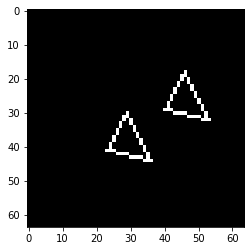

tensor([1., 1., 0., 1.])


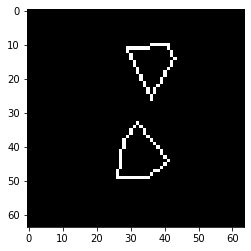

tensor([1., 1., 0., 1.])


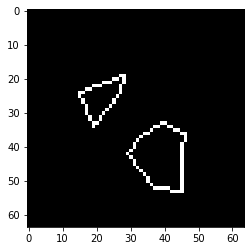

tensor([1., 1., 1., 0.])


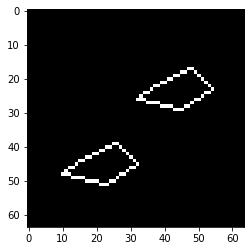

tensor([1., 1., 1., 0.])


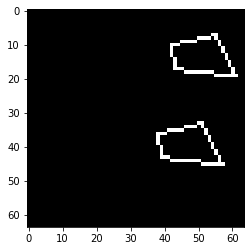

tensor([1., 1., 0., 1.])


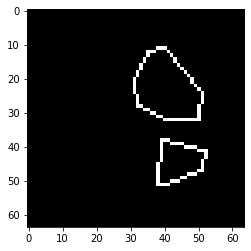

tensor([1., 1., 0., 1.])


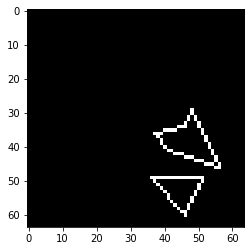

tensor([1., 1., 1., 0.])


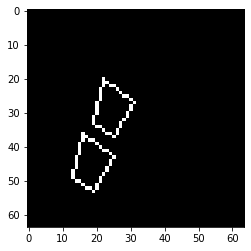

tensor([1., 1., 0., 1.])


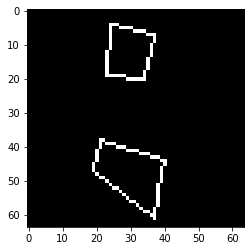

tensor([1., 1., 1., 0.])


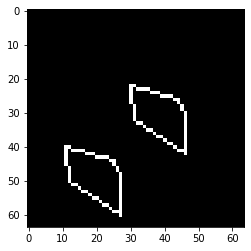

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt

for i in range(10):
    print(tensor_test_ys[i])
    plt.imshow(tensor_test_ims[i][0], cmap='gray')
    plt.show()

#### Examine one of the saved datasets 

tensor([1., 1., 1., 0.])


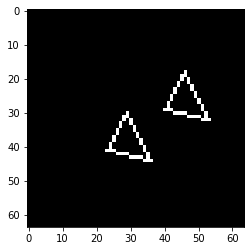

tensor([1., 1., 0., 1.])


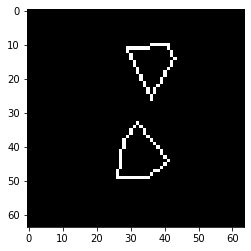

tensor([1., 1., 0., 1.])


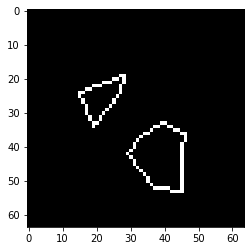

tensor([1., 1., 1., 0.])


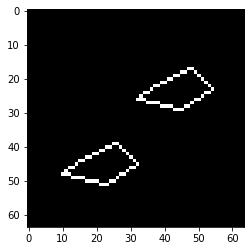

tensor([1., 1., 1., 0.])


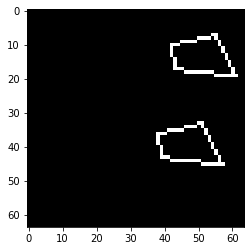

tensor([1., 1., 0., 1.])


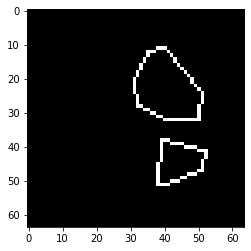

tensor([1., 1., 0., 1.])


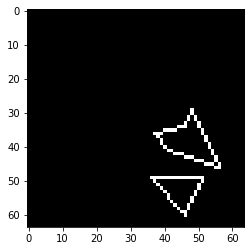

tensor([1., 1., 1., 0.])


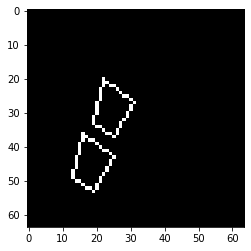

tensor([1., 1., 0., 1.])


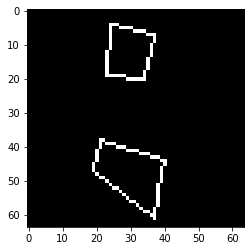

tensor([1., 1., 1., 0.])


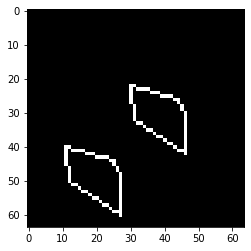

In [10]:

x, y = torch.load(save_dir + 'svrt1_irregular_64_test.pt')
for i in range(10):
    print(y[i])
    plt.imshow(x[i][0], cmap='gray')
    plt.show()